# Tests on RCA data

### RCA > 1 means exports higher than expected from a proportionality rule.

### However RCA cannot be directly used as a scale because there are size effects, or distortions. If we can understand these better we can possibly correct them. 

### A possible application would be to regress against RCA categories (at least three) instead of binary.

In [1]:
import pandas as pd
from pandas import DataFrame,merge,concat,read_csv
import numpy as np
import crisjf_functions as cf
import matplotlib.pyplot as plt

# from requests import get
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D

/home/miglesia/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Import data

In [2]:
#Import data

#Import export and RCA
df = DataFrame.from_csv("i_year_origin_hs02_4.tsv", sep="\t")
df = df.replace(np.nan, 0)

#Products
prods = DataFrame.from_csv("products_hs_02.tsv", sep="\t",header=0)

#Print heading
# print(df.head())
# print(prods.head())

wt, pr, co = cf.trade_data('hs02')

'''
Sample period (SP): 2003 - 2014
Merge these columns (defined at country level):

'mean_gdp_pc': GDP per capita, avg over SP
'mean_gdp' GDP, avg over SP
'tot_growth' GDP(2014) / GDP(2003)
'mean_pop' Population, avg over SP
'''

gdp = DataFrame.from_csv("GDP_Gross.csv", sep=",")
gdp['mean_gdp'] = gdp.ix[:, gdp.columns != 'ccode'].mean(axis = 1)
gdp['tot_growth'] = np.true_divide(gdp['2014'],gdp['2003'])-1

gdppc = DataFrame.from_csv("GDPpercapcurrentUSS.csv", sep=",")
gdppc['mean_gdp_pc'] = gdppc.ix[:, gdppc.columns != 'ccode'].mean(axis = 1)

pop = DataFrame.from_csv("Pop_Total.csv", sep=",")
pop['mean_pop'] = pop.ix[:, pop.columns != 'ccode'].mean(axis = 1)

demo_data = gdppc[['ccode','mean_gdp_pc']].merge(gdp[['ccode','mean_gdp', 'tot_growth']]).merge(pop[['ccode','mean_pop']])
wt = wt.merge(demo_data)

Retrieving trade data for hs02


## Missing values. 

### Small countries (in population and GDP size) are worse reporters.

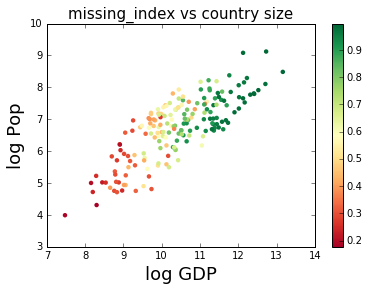

In [3]:
#Scan missing values by country. Note most missing values are in small economies --> we could remove them.

l = wt.groupby(['ccode']).count()['x']
pc = wt.groupby('ccode').pcode.nunique()
yc = wt.groupby('ccode').year.nunique()

data_quality = DataFrame(data={'pc': pc, 'yc' : yc, 'len' : l})
data_quality['ccode'] = data_quality.index
data_quality = data_quality.merge(demo_data[['ccode','mean_gdp','mean_pop']])
data_quality['missing_index'] =  data_quality['len'] / data_quality['pc'] / data_quality['yc']

plt.scatter(np.log10(data_quality['mean_gdp']),np.log10(data_quality['mean_pop']), c = data_quality['missing_index'], cmap = 'RdYlGn', edgecolors = 'none')
plt.xlabel('log GDP', fontsize = 18)
plt.ylabel('log Pop', fontsize = 18)
plt.colorbar()
plt.title('missing_index vs country size',fontsize = 15)
plt.show()

### We could remove worst reporters whithout loosing much (good!).

#### For the moment I keep them 

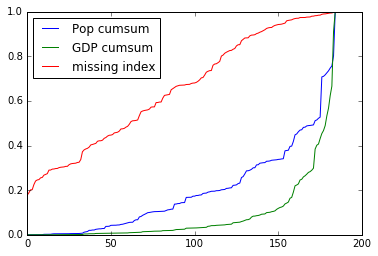

In [4]:
#Check which countries we can remove to get rid of bad quality data while keeping most of the economy and population

#Accumulate population and gdp left out when removing countries, ordered by 'missing_index' value.
data2 = data_quality.sort_values(by = 'missing_index')
data2['gdp_cumsum'] = data2.mean_gdp.cumsum()
data2['pop_cumsum'] = data2.mean_pop.cumsum()

plt.plot(list(data2['pop_cumsum']/max(data2.pop_cumsum)), label = 'Pop cumsum')
plt.plot(list(data2['gdp_cumsum']/max(data2.gdp_cumsum)), label = 'GDP cumsum')
plt.plot(list(data2['missing_index']), label = 'missing index') #1 = optimal, low values = bad quality.
plt.legend(loc = 2)
plt.show()

In [5]:
wt = wt.merge(data_quality[['ccode','missing_index']])

rca_bycountry = wt.groupby(['ccode'])[['mean_gdp','missing_index']].mean()

mean_world_reported_trade = wt['x'].groupby(wt['year']).sum().mean()
mean_reported_trade = np.true_divide(wt.groupby(['ccode'])['x'].sum(),len(wt.year.unique()))
rca_bycountry['trade^-1'] = np.true_divide(mean_world_reported_trade, mean_reported_trade)

rca_bycountry['rca_max'] = wt.groupby(['ccode'])[['export_rca']].max()
rca_bycountry['rca_min'] = wt.loc[wt['export_rca'] > 0].groupby(['ccode'])['export_rca'].min()
rca_bycountry['rca_quantile'] = wt.groupby(['ccode']).quantile(0.7)['export_rca']
rca_bycountry['rca_median'] = wt.groupby(['ccode']).median()['export_rca']
rca_bycountry['rca_mean'] = wt.groupby(['ccode']).mean()['export_rca']

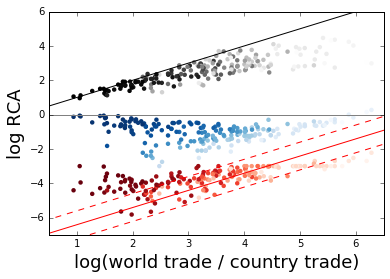

In [6]:
plt.scatter(np.log10(rca_bycountry['trade^-1']), np.log10(rca_bycountry.rca_max), c = rca_bycountry.missing_index, 
            cmap = 'Greys', edgecolors= 'None' )
plt.scatter(np.log10(rca_bycountry['trade^-1']), np.log10(rca_bycountry.rca_median), c = rca_bycountry.missing_index, 
            cmap = 'Blues', edgecolors= 'None' )
# plt.scatter(np.log10(rca_bycountry['trade^-1']), np.log10(rca_bycountry.rca_mean), c = rca_bycountry.missing_index, 
#             cmap = 'Greens', edgecolors= 'None' )
plt.scatter(np.log10(rca_bycountry['trade^-1']), np.log10(rca_bycountry.rca_min), c = rca_bycountry.missing_index, 
            cmap = 'Reds', edgecolors= 'None' )

'''
Some of the size effects:
'''
#Upper limit for RCA. 
plt.plot(range(7), color = 'k')

#Lower limit due to minimum report value US$ 1000. 
#Prod size will make US$ 1000 to differ in RCA.
prod_size_log = np.log10(wt.groupby('pcode').sum()['x'])
m = prod_size_log.mean()
s = prod_size_log.std()

plt.plot(np.arange(3-m+s, 1, 1), color = 'r', ls = 'dashed') 
plt.plot(np.arange(3-m, 0, 1), color = 'r') #3 because of 10^3 USD, m is mean product size.
plt.plot(np.arange(3-m-s, -1, 1), color = 'r', ls = 'dashed')

#RCA = 1 reference
plt.plot(np.zeros(8), color = 'gray')

plt.xlim((0.5, 6.5))
plt.ylim((-7,6))
plt.ylabel('log RCA', fontsize = 18)
plt.xlabel('log(world trade / country trade)', fontsize = 18)
plt.show()


#### Export data is cut at USD 1000. See detail.

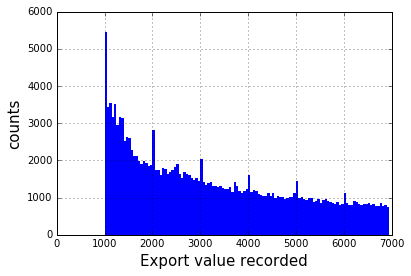

In [7]:
wt['x'].loc[wt['x']<10000].hist(bins = range(0, 7000, 50), edgecolor = 'none')
plt.xlabel('Export value recorded', fontsize = '15')
plt.ylabel('counts', fontsize = '15')
plt.show()

# plt.hist(np.log10(np.array(wt.loc[wt['export_rca'] > 0].groupby(['ccode']).min()['export_rca'])), bins = 20)
# plt.show()

#### Product sizes in USD.

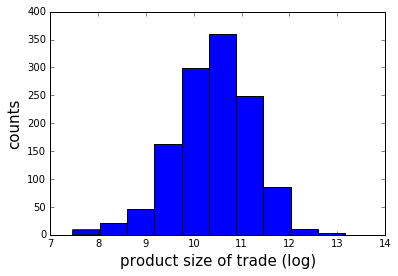

In [8]:
plt.hist(np.log10(wt.groupby('pcode').sum()['x']))
plt.xlabel('product size of trade (log)', fontsize = '15')
plt.ylabel('counts', fontsize = '15')
plt.show()

In [9]:
# pcount = wt.groupby(['ccode']).x.count()
# M = max(pcount)
# s['rca1_quantile'] = np.true_divide(wt.loc[wt['export_rca'] > 1].groupby(['ccode']).x.count(),pcount)
# # plt.plot(np.log10(s.inv), s.rca1_quantile)
# plt.scatter(np.log10(s.inv), s.rca1_quantile, c = s.missing_index, cmap = 'Greys', edgecolors= 'None' )

# # s['rca1_quantile'] = np.true_divide(wt.loc[wt['export_rca'] > 9].groupby(['ccode']).x.count(),pcount)
# # plt.plot(np.log10(s.inv), s.rca1_quantile)
# # plt.scatter(np.log10(s.inv), s.rca1_quantile, c = s.missing_index, cmap = 'Reds', edgecolors= 'None' )
# plt.show()


In [10]:

# # s['inv']
# s['ccode'] = s.index
# wt = wt.merge(s[['ccode','inv']])
# df = wt[['export_rca','inv']]
# df['log_export_rca'] = np.log10(df.export_rca)
# df['log_inv'] = np.log10(df.inv)


In [11]:
# xedges = np.arange(0,6, 0.14)
# yedges = np.arange(-6,6,0.1)

# x = df['log_inv']
# y = df['log_export_rca']
# H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
# H = H.T  # Let each row list bins with common y range.

# fig = plt.figure(figsize=(5, 5))

# ax = fig.add_subplot(111, title='')
# X, Y = np.meshgrid(xedges, yedges)
# ax.pcolormesh(X, Y, H, cmap = 'Greys')

# plt.plot(range(7))
# plt.plot(np.arange(-6.6, 0, 1))
# # plt.plot(np.arange(-7.4, 0, 1))
# plt.plot(np.arange(-8.2, -2, 1))
# plt.plot(np.zeros(7))
